In [1]:
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

import matplotlib.cm as cm
import matplotlib as mpl
import pynbody
import math
import numpy as np
import socket
# from bulk import *
import copy
import pickle
import pandas as pd

# we set the global matplotlib parameters so the fonts are all consistent and serif 
mpl.rc('font',**{'family':'serif','monospace':['Palatino']})
mpl.rc('text', usetex=True)
mpl.rcParams.update({'font.size': 9})

In [2]:
def read_file(simname):
    ### leave this section as is
    data = []
    with open('/home/akinshol/Data/DataFiles_Archive_20191129/'+ simname + '.data', 'rb') as f:
        while True:
            try:
                data.append(pickle.load(f,encoding='latin1'))
            except EOFError:
                break

        data1 = pd.DataFrame(data)
        data1['sim'] = [simname]*len(data1)
        data1['g-r'] = 1.646*(data1['V_mag'] - data1['R_mag']) - 0.139
        return data1

In [2]:
# from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

def plt_halos_full(name,tfile,outfilebase,tfile_base,*halo_nums, width_wide=1500, width_narrow=800, circles_on_dm_only=False):

    #min_mass = 1e9 #Minimum halo mass for analysis in solar masses
    min_nstar =  100 #Minimum number of stars for
    min_vmass = 1e8
    min_noncontamFrac = 0.9 #Mass fraction in low mass DM particles

    if halo_nums:
        halo_nums = halo_nums[0]
        
    s = pynbody.load(tfile)
    s.physical_units()
    h = s.halos()
    h_dummy = s.halos(dummy = True)
    print('Loaded simulation')

    fig1, ax1 = plt.subplots(2,3, figsize=(9.5,7),dpi=500)
    
    labels = []

    i = 0
    #Loop through all the halos, breaking when the virial mass is below min_mass
    h1x = h_dummy[1].properties['Xc']
    h1y = h_dummy[1].properties['Yc']
    h1z = h_dummy[1].properties['Zc']
    
    width = width_wide
    smin, smax = -width//2, width//2
    print('Centering halo 1')
    pynbody.analysis.halo.center(h[1])
    
    # h148
#     dm_vmin, dm_vmax = 1e2, 1e8
#     gas_vmin, gas_vmax = 1e2, 1e8
#     star_vmin, star_vmax = 1e2, 1e9
    

    # h329 
    dm_vmin, dm_vmax = 8e1, 8e7
    gas_vmin, gas_vmax = 1e1, 3e7
    star_vmin, star_vmax = 5e0, 1e8
    
    
    print('Making DM image...')
    im = pynbody.plot.sph.image(s.dm[pynbody.filt.Sphere('%s kpc' % str((smax-smin)))], width = '%s kpc' % str(smax-smin), cmap='Greys_r', 
                                av_z = 'rho', ret_im = True, show_cbar = False, noplot=True)
    
    im = ax1[0,0].imshow(im, norm=colors.LogNorm(), cmap='Greys_r', extent = [smin,smax,smin,smax], vmin=dm_vmin, vmax=dm_vmax,origin='lower')
    
    print('Making gas image...')
    im = pynbody.plot.sph.image(s.gas[pynbody.filt.Sphere('%s kpc' % str((smax-smin)))], width = '%s kpc' % str(smax-smin), cmap='viridis', 
                                av_z = 'rho', ret_im = True, show_cbar = False, noplot=True)
    
    im = ax1[0,1].imshow(im, norm=colors.LogNorm(), cmap='viridis', extent = [smin,smax,smin,smax], vmin=gas_vmin, vmax=gas_vmax,origin='lower')

    
    print('Making star image...')
    im = pynbody.plot.sph.image(s.s[pynbody.filt.Sphere('%s kpc' % str((smax-smin)))], width = '%s kpc' % str(smax-smin), cmap='cubehelix', 
                                av_z = 'rho', ret_im = True, show_cbar = False, noplot=True)
    
    my_cmap = copy.copy(mpl.cm.get_cmap('cubehelix')) # copy the default cmap
    my_cmap.set_bad(my_cmap(0))
    
    im = ax1[0,2].imshow(im, norm=colors.LogNorm(), cmap=my_cmap, extent= [smin,smax,smin,smax], vmin=star_vmin, vmax=star_vmax,origin='lower')
    
    
    width = width_narrow
    smin, smax = -width//2, width//2
    print('Centering halo 1')
    pynbody.analysis.halo.center(h[1])
    
    print('Making zoomed DM image...')
    im = pynbody.plot.sph.image(s.dm[pynbody.filt.Sphere('%s kpc' % str((smax-smin)))], width = '%s kpc' % str(smax-smin), cmap='Greys_r', 
                                av_z = 'rho', ret_im = True, show_cbar = False, noplot=True)
    
    im = ax1[1,0].imshow(im, norm=colors.LogNorm(), cmap='Greys_r', extent = [smin,smax,smin,smax], vmin=dm_vmin, vmax=dm_vmax,origin='lower')
    
    divider = make_axes_locatable(ax1[1,0])
    cax = divider.new_vertical(size="5%", pad=0.1, pack_start=True)
    fig1.add_axes(cax)
    cbar = fig1.colorbar(im, cax=cax, orientation="horizontal")
    cbar.set_label(r'Dark Matter Density [$\mathrm{M}_{\odot}\ \mathrm{kpc}^{-3}$]')
    cbar.ax.minorticks_on()
    
    print('Making zoomed gas image...')
    im = pynbody.plot.sph.image(s.gas[pynbody.filt.Sphere('%s kpc' % str((smax-smin)))], width = '%s kpc' % str(smax-smin), cmap='viridis', 
                                av_z = 'rho', ret_im = True, show_cbar = False, noplot=True)
    
    im = ax1[1,1].imshow(im, norm=colors.LogNorm(), cmap='viridis', extent = [smin,smax,smin,smax], vmin=gas_vmin, vmax=gas_vmax,origin='lower')
    
    divider = make_axes_locatable(ax1[1,1])
    cax = divider.new_vertical(size="5%", pad=0.1, pack_start=True)
    fig1.add_axes(cax)
    cbar = fig1.colorbar(im, cax=cax, orientation="horizontal")
    cbar.set_label(r'Gas Density [$\mathrm{M}_{\odot}\ \mathrm{kpc}^{-3}$]')
    cbar.ax.minorticks_on()
    
    print('Making zoomed star image...')
    im = pynbody.plot.sph.image(s.s[pynbody.filt.Sphere('%s kpc' % str((smax-smin)))], width = '%s kpc' % str(smax-smin), cmap='cubehelix', 
                                av_z = 'rho', ret_im = True, show_cbar = False, noplot=True)
    
    my_cmap = copy.copy(mpl.cm.get_cmap('cubehelix')) # copy the default cmap
    my_cmap.set_bad(my_cmap(0))
    
    im = ax1[1,2].imshow(im, norm=colors.LogNorm(), cmap=my_cmap, extent= [smin,smax,smin,smax], vmin=star_vmin, vmax=star_vmax,origin='lower')
    
    divider = make_axes_locatable(ax1[1,2])
    cax = divider.new_vertical(size="5%", pad=0.1, pack_start=True)
    fig1.add_axes(cax)
    cbar = fig1.colorbar(im, cax=cax, orientation="horizontal")
    cbar.set_label(r'Stellar Density [$\mathrm{M}_{\odot}\ \mathrm{kpc}^{-3}$]')
    cbar.ax.minorticks_on()
    
    data = read_file(name) 
    
    h1rvir = 0
    print('Adding circles...')
    for ihalo in range(1,len(h)): #len(h)-1):
        
        if not halo_nums:
            nstar = h_dummy[ihalo].properties['n_star']
            fMhires = h_dummy[ihalo].properties['fMhires']
            mass = h_dummy[ihalo].properties['mass']
            valid_halo = (nstar >= min_nstar) and (fMhires >= min_noncontamFrac) and (mass >= min_vmass)
        else:
            valid_halo = str(h_dummy[ihalo].properties['halo_id']) in halo_nums

            
        if valid_halo:
            labels.append(str(ihalo))
            print(h_dummy[ihalo].properties['halo_id'])
            
            
            x = (h_dummy[ihalo].properties['Xc']-h1x)/0.6776942783267969
            y = (h_dummy[ihalo].properties['Yc']-h1y)/0.6776942783267969
            z = (h_dummy[ihalo].properties['Zc']-h1z)/0.6776942783267969
            rvir = h_dummy[ihalo].properties['Rvir']/0.6776942783267969
            
            
            if float(data[data.haloid==ihalo].sSFR.tolist()[0]) < 1e-11:
                colorVal = '#ff837a'
            else:
                colorVal = '#79aefc'
            
            if ihalo==1:
                h1rvir = rvir
                style = '-'
                colorVal = 'w'
                width=1.5
            else:
                width=1.
                dist = math.sqrt(x*x + y*y + z*z)
                if dist < h1rvir:
                    style = '--'
                else:
                    style = '-'
                    
            
                

            
            circlexy1 = plt.Circle((x,y),rvir,color = colorVal, linestyle=style, fill=False, linewidth=width)
            circlexy2 = plt.Circle((x,y),rvir,color = colorVal, linestyle=style, fill=False, linewidth=width)
            circlexy3 = plt.Circle((x,y),rvir,color = colorVal, linestyle=style, fill=False, linewidth=width)
            circlexy4 = plt.Circle((x,y),rvir,color = colorVal, linestyle=style, fill=False, linewidth=width)
            circlexy5 = plt.Circle((x,y),rvir,color = colorVal, linestyle=style, fill=False, linewidth=width)
            circlexy6 = plt.Circle((x,y),rvir,color = colorVal, linestyle=style, fill=False, linewidth=width)
            

            ax1[0,0].add_artist(circlexy1)
            ax1[1,0].add_artist(circlexy2)
            
            if ihalo==1:
                ax1[0,1].add_artist(circlexy3)
                ax1[1,1].add_artist(circlexy4)
                ax1[0,2].add_artist(circlexy5)
                ax1[1,2].add_artist(circlexy6)
            
            if not circles_on_dm_only:
                ax1[0,1].add_artist(circlexy3)
                ax1[1,1].add_artist(circlexy4)
                ax1[0,2].add_artist(circlexy5)
                ax1[1,2].add_artist(circlexy6)

            fig1.show()
            i += 1
            
            
    #ax1.set_title(tfile_base)
    #ax1.legend(labels,loc = 1)
    
    for j in [0,1]:
        for i in [0,1,2]:
            ax1[j,i].tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
            ax1[j,i].tick_params(axis='y',which='both',left=False,right=False,labelleft=False)

    

    plt.subplots_adjust(wspace=0.05,hspace=0.02)
    fig1.show()
    fig1.savefig(outfilebase + '.halos_xy.png',dpi=300)

    fig1.clear()

In [4]:
# from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

def plt_halos(name,tfile,outfilebase,tfile_base,*halo_nums, width=1000, circles_on_dm_only=True):

    #min_mass = 1e9 #Minimum halo mass for analysis in solar masses
    min_nstar =  100 #Minimum number of stars for
    min_vmass = 1e8
    min_noncontamFrac = 0.9 #Mass fraction in low mass DM particles

    if halo_nums:
        halo_nums = halo_nums[0]
        
    s = pynbody.load(tfile)
    s.physical_units()
    h = s.halos()
    h_dummy = s.halos(dummy = True)
    print('Loaded simulation')
    
    
    #plt.style.use('dark_background')
    fig1, ax1 = plt.subplots(1,3, figsize=(9.5,3.7),dpi=500)
    
    labels = []

    i = 0

    h1x = h_dummy[1].properties['Xc']
    h1y = h_dummy[1].properties['Yc']
    h1z = h_dummy[1].properties['Zc']
    
#     #h148
    dm_vmin, dm_vmax = 1e2, 9e7
    gas_vmin, gas_vmax = 1e2, 9e7
    star_vmin, star_vmax = 1e2, 1e9

#     # h229
#     dm_vmin, dm_vmax = 1e2, 9e7
#     gas_vmin, gas_vmax = 1e2, 2e7
#     star_vmin, star_vmax = 1e2, 4e8
    
#     # h329 
#     dm_vmin, dm_vmax = 8e1, 8e7
#     gas_vmin, gas_vmax = 1e1, 3e7
#     star_vmin, star_vmax = 5e0, 1e8
    
    
    smin, smax = -width//2, width//2
    print('Centering halo 1')
    pynbody.analysis.halo.center(h[1])
    
    print('Making DM image...')
    im = pynbody.plot.sph.image(s.dm[pynbody.filt.Sphere('%s kpc' % str((smax-smin)))], width = '%s kpc' % str(smax-smin), cmap='Greys_r', 
                                av_z = 'rho', ret_im = True, show_cbar = False, noplot=True)
    
    im = ax1[0].imshow(im, norm=colors.LogNorm(), cmap='Greys_r', extent = [smin,smax,smin,smax], vmin=dm_vmin, vmax=dm_vmax,origin='lower')
    
    divider = make_axes_locatable(ax1[0])
    cax = divider.new_vertical(size="5%", pad=0.1, pack_start=True)
    fig1.add_axes(cax)
    cbar = fig1.colorbar(im, cax=cax, orientation="horizontal")
    cbar.set_label(r'Dark Matter Density [$\mathrm{M}_{\odot}\ \mathrm{kpc}^{-3}$]')
    cbar.ax.minorticks_on()
    
    print('Making gas image...')
    im = pynbody.plot.sph.image(s.gas[pynbody.filt.Sphere('%s kpc' % str((smax-smin)))], width = '%s kpc' % str(smax-smin), cmap='viridis', 
                                av_z = 'rho', ret_im = True, show_cbar = False, noplot=True)
    
    im = ax1[1].imshow(im, norm=colors.LogNorm(), cmap='viridis', extent = [smin,smax,smin,smax], vmin=gas_vmin, vmax=gas_vmax,origin='lower')
    
    divider = make_axes_locatable(ax1[1])
    cax = divider.new_vertical(size="5%", pad=0.1, pack_start=True)
    fig1.add_axes(cax)
    cbar = fig1.colorbar(im, cax=cax, orientation="horizontal")
    cbar.set_label(r'Gas Density [$\mathrm{M}_{\odot}\ \mathrm{kpc}^{-3}$]')
    cbar.ax.minorticks_on()
    
    print('Making star image...')
    im = pynbody.plot.sph.image(s.s[pynbody.filt.Sphere('%s kpc' % str((smax-smin)))], width = '%s kpc' % str(smax-smin), cmap='cubehelix', 
                                av_z = 'rho', ret_im = True, show_cbar = False, noplot=True)
    
    my_cmap = copy.copy(mpl.cm.get_cmap('cubehelix')) # copy the default cmap
    my_cmap.set_bad(my_cmap(0))
    
    im = ax1[2].imshow(im, norm=colors.LogNorm(), cmap=my_cmap, extent= [smin,smax,smin,smax], vmin=star_vmin, vmax=star_vmax,origin='lower')
    
    divider = make_axes_locatable(ax1[2])
    cax = divider.new_vertical(size="5%", pad=0.1, pack_start=True)
    fig1.add_axes(cax)
    cbar = fig1.colorbar(im, cax=cax, orientation="horizontal")
    cbar.set_label(r'Stellar Density [$\mathrm{M}_{\odot}\ \mathrm{kpc}^{-3}$]')
    cbar.ax.minorticks_on()
    
    data = read_file(name) 
    
    h1rvir = 0
    
    print('Adding circles...')
    for ihalo in range(1,len(h)): #len(h)-1):
        
        if not halo_nums:
            nstar = h_dummy[ihalo].properties['n_star']
            fMhires = h_dummy[ihalo].properties['fMhires']
            mass = h_dummy[ihalo].properties['mass']
            valid_halo = (nstar >= min_nstar) and (fMhires >= min_noncontamFrac) and (mass >= min_vmass)
        else:
            valid_halo = str(h_dummy[ihalo].properties['halo_id']) in halo_nums

            
        if valid_halo:
            labels.append(str(ihalo))
            print(h_dummy[ihalo].properties['halo_id'])
            
            
            x = (h_dummy[ihalo].properties['Xc']-h1x)/0.6776942783267969
            y = (h_dummy[ihalo].properties['Yc']-h1y)/0.6776942783267969
            z = (h_dummy[ihalo].properties['Zc']-h1z)/0.6776942783267969
            rvir = h_dummy[ihalo].properties['Rvir']/0.6776942783267969
            
            
            if float(data[data.haloid==ihalo].sSFR.tolist()[0]) < 1e-11:
                colorVal = '#ff837a'
            else:
                colorVal = '#79aefc'
            
            if ihalo==1:
                h1rvir = rvir
                style = '-'
                colorVal = 'w'
                width=1.5
            else:
                width=1.
                dist = math.sqrt(x*x + y*y + z*z)
                if dist < h1rvir:
                    style = '--'
                else:
                    style = '-'
                    
            
                

            
            circlexy1 = plt.Circle((x,y),rvir,color = colorVal, linestyle=style, fill=False, linewidth=width)

            circlexy3 = plt.Circle((x,y),rvir,color = colorVal, linestyle=style, fill=False, linewidth=width)
            circlexy4 = plt.Circle((x,y),rvir,color = colorVal, linestyle=style, fill=False, linewidth=width)
            

            ax1[0].add_artist(circlexy1)
            
            if ihalo==1:
                ax1[1].add_artist(circlexy3)
                ax1[2].add_artist(circlexy4)
            
            if not circles_on_dm_only:
                ax1[1].add_artist(circlexy3)
                ax1[2].add_artist(circlexy4)

            fig1.show()
            i += 1
            
            
    #ax1.set_title(tfile_base)
    #ax1.legend(labels,loc = 1)
    
    for i in [0,1,2]:
        ax1[i].tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
        ax1[i].tick_params(axis='y',which='both',left=False,right=False,labelleft=False)

    

    plt.subplots_adjust(wspace=0.05,hspace=0.01)
    fig1.show()
    fig1.savefig(outfilebase + '.halos_xy.png',dpi=300)

    fig1.clear()

# Sandra

In [5]:
prefix_outfile = '/home/akinshol/Data/S20/'

tfile_base = 'h148.cosmo50PLK.3072g3HbwK1BH.004096'
tfile = '/home/christenc/Data/Sims/h148.cosmo50PLK.3072g/h148.cosmo50PLK.3072g3HbwK1BH/snapshots_200bkgdens/h148.cosmo50PLK.3072g3HbwK1BH.004096'   

outfile_base = prefix_outfile + 'h148_Apr18'
plt_halos('h148',tfile,outfile_base,tfile_base, width=600, circles_on_dm_only=True)

Loaded simulation
Centering halo 1
Making DM image...
Making gas image...
Making star image...
Adding circles...
1
2
3
5
6
9
10
11
13
14
21
24
27
28
32
36
37
45
61
68
80
96
128
163
265
278
283
329


<Figure size 4750x1850 with 0 Axes>

# Sonia

In [6]:
prefix_outfile = '/home/akinshol/Data/S20/'

tfile_base = 'h242.cosmo50PLK.3072gst5HbwK1BH.004096'
tfile = '/home/christenc/Data/Sims/h242.cosmo50PLK.3072g/h242.cosmo50PLK.3072gst5HbwK1BH/snapshots_200bkgdens/h242.cosmo50PLK.3072gst5HbwK1BH.004096'

outfile_base = prefix_outfile + 'h242_Apr18'
plt_halos('h242',tfile,outfile_base,tfile_base, width=600, circles_on_dm_only=True)

Loaded simulation
Centering halo 1
Making DM image...
Making gas image...
Making star image...
Adding circles...
1
10
12
24
30
34
40
41
44
78
80


<Figure size 4750x1850 with 0 Axes>

# Ruth

In [12]:
prefix_outfile = '/home/akinshol/Data/S20/'

tfile_base = 'h229.cosmo50PLK.3072gst5HbwK1BH.004096'
tfile = '/home/christenc/Data/Sims/h229.cosmo50PLK.3072g/h229.cosmo50PLK.3072gst5HbwK1BH/snapshots_200bkgdens/h229.cosmo50PLK.3072gst5HbwK1BH.004096'

outfile_base = prefix_outfile + 'h229'
plt_halos('h229',tfile,outfile_base,tfile_base)

Loaded simulation
Centering halo 1
Making DM image...
Making gas image...
Making star image...


/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/pynbody/array.py:346: RuntimeWarning: divide by zero encountered in true_divide
  return np.ndarray.__truediv__(self, rhs)
/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/pynbody/array.py:346: RuntimeWarning: invalid value encountered in true_divide
  return np.ndarray.__truediv__(self, rhs)
/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:173: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


<Figure size 4750x1850 with 0 Axes>

# Sonia

In [13]:
prefix_outfile = '/home/akinshol/Data/S20/'

tfile_base = 'h242.cosmo50PLK.3072gst5HbwK1BH.004096'
tfile = '/home/christenc/Data/Sims/h242.cosmo50PLK.3072g/h242.cosmo50PLK.3072gst5HbwK1BH/snapshots_200bkgdens/h242.cosmo50PLK.3072gst5HbwK1BH.004096'

outfile_base = prefix_outfile + 'h242'
plt_halos('h242',tfile,outfile_base,tfile_base)

Loaded simulation
Centering halo 1
Making DM image...
Making gas image...
Making star image...


/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/pynbody/array.py:346: RuntimeWarning: divide by zero encountered in true_divide
  return np.ndarray.__truediv__(self, rhs)
/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/pynbody/array.py:346: RuntimeWarning: invalid value encountered in true_divide
  return np.ndarray.__truediv__(self, rhs)
/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:173: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


<Figure size 4750x1850 with 0 Axes>

# Elena

In [14]:
prefix_outfile = '/home/akinshol/Data/S20/'

tfile_base = 'h329.cosmo50PLK.3072gst5HbwK1BH.004096'
tfile = '/home/christenc/Data/Sims/h329.cosmo50PLK.3072g/h329.cosmo50PLK.3072gst5HbwK1BH/snapshots_200bkgdens/h329.cosmo50PLK.3072gst5HbwK1BH.004096'

outfile_base = prefix_outfile + 'h329'
plt_halos('h329',tfile,outfile_base,tfile_base)

Loaded simulation
Centering halo 1
Making DM image...
Making gas image...
Making star image...


/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/pynbody/array.py:346: RuntimeWarning: divide by zero encountered in true_divide
  return np.ndarray.__truediv__(self, rhs)
/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/pynbody/array.py:346: RuntimeWarning: invalid value encountered in true_divide
  return np.ndarray.__truediv__(self, rhs)
/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:173: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


<Figure size 4750x1850 with 0 Axes>

In [26]:
prefix_outfile = '/home/akinshol/Data/Final Notebooks/images/'

tfile_base = 'h329.cosmo50PLK.3072gst5HbwK1BH.004096'
tfile = '/home/christenc/Data/Sims/h329.cosmo50PLK.3072g/h329.cosmo50PLK.3072gst5HbwK1BH/snapshots_200bkgdens/h329.cosmo50PLK.3072gst5HbwK1BH.004096'   

outfile_base = prefix_outfile + 'h329_full'
plt_halos('h329',tfile,outfile_base,tfile_base, circles_on_dm_only=True)

Loaded simulation
Centering halo 1
Making DM image...
Making gas image...
Making star image...
Centering halo 1
Making zoomed DM image...
Making zoomed gas image...
Making zoomed star image...
Adding circles...
1


/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


11
33
133
137


/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:196: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


<Figure size 4750x3500 with 0 Axes>

In [69]:
data = read_file('h329')

In [75]:
data[data.haloid==11].sSFR.tolist()[0]

4.124049056743271e-11

/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  This is separate from the ipykernel package so we can avoid doing imports until


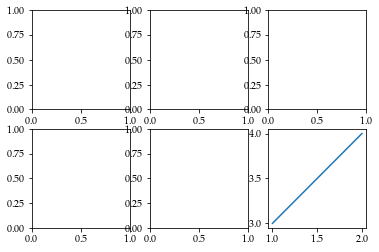

In [4]:
fig, ax = plt.subplots(2,3)
ax[1,2].plot([1,2],[3,4])
fig.show()

NameError: name 'im' is not defined

In [18]:
my_cmap = copy.copy(mpl.cm.get_cmap('cubehelix')) # copy the default cmap
my_cmap.set_bad(my_cmap.colors[0])

AttributeError: 'LinearSegmentedColormap' object has no attribute 'colors'

In [24]:
my_cmap(0)

(0.0, 0.0, 0.0, 1.0)

In [3]:

snapnums_h148 = ['004096', '003968', '003840', '003712', '003606', '003584', '003456', '003328', '003200', '003195', '003072', '002944', '002816', '002688', '002554', '002432', '002304', '002176', '002088', '002048', '001920', '001740', '001536', '001408', '001280', '001269', '001152', '001106', '001024', '000974', '000896', '000866', '000768', '000701', '000640', '000512', '000456', '000384', '000347', '000275', '000225', '000188', '000139']

haloids_h148 = {
    1: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 10, 13, 40, 45, 54],
    2: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 6, 5, 5, 5, 5, 6, 4, 5, 6, 18, 25, 33, 15, 19, 24],
    3: [3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 4, 4, 4, 4, 4, 6, 11, 12, 11, 13, 14, 17, 16, 14, 18, 10, 8, 5, 4],
    5: [5, 5, 5, 4, 4, 4, 4, 4, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 6, 6, 6, 6, 6, 7, 7, 7, 6, 7, 10, 14, 10, 8, 10, 7, 5, 3, 3, 4, 5],
    6: [6, 6, 6, 6, 6, 6, 6, 5, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 7, 7, 8, 8, 8, 8, 10, 10, 8, 8, 8, 12, 15, 18, 17, 17, 16, 54, 47, 46, 44],
    9: [9, 9, 9, 9, 7, 7, 7, 7, 8, 8, 8, 8, 9, 9, 9, 9, 8, 8, 8, 8, 8, 8, 9, 9, 11, 11, 9, 9, 12, 12, 9, 9, 7, 10, 23, 20, 19, 19, 23, 22, 11, 9, 55],
    10: [10, 10, 11, 11, 11, 11, 12, 12, 13, 13, 13, 13, 13, 13, 13, 14, 14, 13, 13, 13, 13, 13, 18, 18, 20, 20, 20, 20, 22, 21, 29, 29, 34, 36, 42, 51, 72, 112, 123, 211, 613],
    11: [11, 11, 10, 10, 10, 10, 11, 11, 12, 12, 10, 11, 10, 19, 10, 10, 10, 10, 10, 10, 10, 10, 11, 12, 15, 15, 18, 18, 16, 16, 20, 20, 32, 34, 39, 39, 39, 40, 42, 29, 14, 12, 16],
    13: [13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 15, 12, 12, 11, 11, 11, 11, 11, 11, 11, 12, 13, 13, 13, 14, 14, 15, 15, 18, 18, 17, 18, 16, 16, 25, 23, 20, 12, 9, 11, 9],
    14: [14, 14, 14, 12, 12, 12, 13, 13, 15, 15, 15, 15, 14, 14, 14, 15, 15, 15, 15, 15, 16, 16, 19, 24, 42, 42, 47, 44, 46, 49, 54, 57, 69, 74, 71, 71, 73, 109, 113, 121, 193, 232],
    21: [21, 19, 18, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 18, 19, 19, 19, 18, 17, 17, 18, 17, 22, 22, 27, 28, 35, 36, 42, 65, 85, 84, 82, 88, 91, 173, 194, 263, 347, 401, 450, 445, 320],
    24: [24, 24, 24, 23, 23, 24, 24, 24, 25, 25, 25, 24, 24, 26, 26, 26, 27, 28, 29, 30, 32, 33, 35, 35, 36, 36, 38, 37, 38, 41, 42, 41, 45, 54, 74, 118, 111, 132, 214, 313, 518],
    27: [27, 28, 28, 28, 29, 29, 25, 23, 23, 23, 18, 19, 18, 16, 18, 17, 17, 14, 14, 14, 14, 15, 17, 17, 19, 19, 22, 22, 24, 24, 27, 27, 25, 26, 29, 32, 33, 41, 48, 125, 243, 343],
    28: [28, 29, 29, 29, 27, 26, 22, 19, 19, 19, 19, 18, 19, 17, 17, 16, 16, 17, 19, 19, 12, 12, 13, 15, 17, 18, 17, 16, 17, 18, 22, 24, 23, 24, 22, 45, 61, 118, 129, 110, 108, 101, 182],
    30: [30, 31, 31, 31, 32, 33, 33, 32, 31, 31, 32, 30, 30, 31, 32, 31, 35, 46, 51, 51, 54, 60, 64, 66, 72, 71, 69, 70, 68, 66, 77, 78, 94, 101, 108, 123, 141, 163, 174, 199, 163, 116, 107],
    32: [32, 27, 27, 26, 26, 27, 27, 26, 27, 27, 27, 27, 27, 28, 27, 27, 28, 26, 28, 29, 30, 29, 32, 38, 45, 47, 52, 54, 53, 53, 59, 59, 64, 63, 64, 92, 233, 229, 248, 271, 303, 375, 369],
    36: [36, 35, 33, 40, 34, 34, 31, 29, 28, 28, 26, 26, 26, 25, 24, 25, 24, 25, 26, 26, 27, 28, 33, 33, 33, 33, 36, 35, 37, 42, 44, 44, 46, 48, 51, 53, 54, 56, 66, 83, 85, 102, 269],
    37: [37, 37, 36, 34, 35, 36, 35, 34, 34, 34, 34, 32, 28, 23, 23, 24, 23, 24, 23, 25, 26, 26, 28, 28, 28, 29, 33, 34, 36, 39, 45, 45, 48, 52, 59, 108, 128, 206, 209, 224, 277],
    41: [41, 40, 40, 42, 43, 44, 45, 46, 46, 46, 50, 48, 49, 48, 45, 47, 46, 47, 48, 49, 52, 54, 60, 61, 61, 61, 58, 60, 63, 70, 93, 93, 112, 123, 129, 126, 124, 146, 188, 302, 269, 216],
    45: [45, 43, 43, 39, 40, 41, 39, 38, 36, 36, 36, 35, 32, 30, 28, 22, 20, 19, 18, 20, 22, 19, 23, 21, 24, 24, 27, 27, 32, 32, 30, 30, 31, 37, 50, 63, 65, 75, 154, 172, 285, 351, 297],
    47: [47, 47, 46, 45, 47, 47, 46, 45, 45, 45, 48, 45, 45, 47, 44, 46, 45, 45, 45, 47, 50, 52, 83, 81, 88, 91, 107, 281, 251, 230, 191, 181, 187, 226, 235, 262, 288, 470, 424, 595, 620, 471],
    48: [48, 48, 38, 32, 31, 32, 30, 31, 32, 32, 33, 34, 34, 34, 34, 34, 34, 34, 34, 36, 40, 39, 43, 47, 54, 56, 63, 65, 66, 62, 66, 75, 91, 97, 112, 195, 360, 483, 523, 830],
    58: [58, 60, 60, 60, 60, 61, 63, 64, 67, 66, 67, 67, 69, 72, 73, 72, 70, 75, 77, 76, 79, 82, 96, 101, 107, 105, 103, 105, 108, 114, 121, 122, 123, 132, 135, 152, 173, 171, 176, 230, 262, 201],
    61: [61, 62, 62, 57, 59, 60, 61, 60, 59, 59, 55, 55, 47, 42, 40, 40, 41, 42, 43, 46, 49, 49, 57, 59, 64, 64, 64, 63, 67, 63, 67, 68, 74, 78, 85, 98, 98, 96, 98, 91, 68, 48, 46],
    65: [65, 64, 65, 64, 57, 57, 52, 48, 47, 47, 49, 47, 48, 50, 54, 54, 52, 56, 59, 58, 60, 61, 67, 70, 122, 132, 162, 189, 204, 212, 212, 206, 186, 187, 188, 199, 209, 214, 202, 194, 212, 263, 277],
    68: [68, 51, 49, 46, 45, 45, 44, 43, 42, 42, 41, 37, 39, 27, 21, 21, 21, 21, 22, 23, 24, 21, 25, 25, 25, 25, 28, 30, 34, 38, 40, 46, 126, 152, 160, 203, 238, 254, 283, 662, 756],
    80: [80, 69, 66, 55, 51, 51, 49, 44, 41, 41, 39, 33, 31, 32, 30, 29, 30, 23, 21, 21, 21, 27, 21, 20, 22, 22, 24, 24, 25, 25, 28, 28, 28, 31, 30, 28, 26, 22, 29, 32, 28, 33, 25],    
    81: [81, 91, 77, 73, 70, 70, 69, 69, 63, 62, 58, 54, 60, 63, 74, 76, 74, 80, 79, 79, 81, 84, 117, 137, 155, 153, 164, 169, 187, 187, 205, 203, 215, 232, 255, 299, 299, 329, 303, 256, 295, 282, 195],
    96: [96, 97, 99, 99, 95, 93, 92, 90, 86, 86, 87, 99, 59, 54, 55, 53, 49, 49, 53, 53, 53, 56, 61, 64, 67, 67, 67, 71, 69, 68, 73, 70, 73, 75, 83, 103, 109, 121, 118, 92, 65, 47, 28],
    105: [105, 105, 107, 108, 107, 109, 113, 111, 113, 112, 113, 121, 118, 121, 122, 124, 125, 129, 132, 131, 136, 137, 147, 159, 175, 174, 174, 177, 179, 177, 188, 184, 194, 207, 216, 246, 263, 251, 266, 294, 266, 200, 143],
    119: [119, 120, 128, 129, 129, 130, 132, 132, 130, 129, 132, 128, 124, 119, 110, 110, 106, 106, 101, 102, 96, 90, 89, 102, 116, 115, 120, 126, 130, 133, 135, 137, 137, 135, 142, 186, 190, 202, 193, 212, 881],
    127: [127, 124, 118, 117, 116, 117, 85, 37, 37, 37, 37, 38, 37, 39, 37, 38, 38, 36, 36, 38, 41, 42, 48, 53, 53, 53, 55, 56, 57, 56, 69, 74, 81, 93, 128, 148, 155, 200, 197, 167, 151, 174, 246],
    128: [128, 130, 132, 131, 127, 128, 123, 113, 109, 109, 104, 100, 100, 98, 79, 68, 66, 66, 68, 69, 72, 73, 75, 73, 78, 77, 74, 79, 77, 76, 82, 82, 85, 89, 89, 85, 106, 211, 236, 259, 237, 328, 346],
    136: [136, 136, 141, 143, 144, 145, 146, 151, 153, 153, 155, 158, 159, 159, 154, 151, 199, 125, 122, 119, 108, 108, 98, 114, 82, 81, 83, 82, 80, 84, 89, 88, 111, 116, 122, 155, 164, 167, 165, 153, 120, 99, 122],
    163: [163, 163, 171, 172, 171, 174, 176, 184, 183, 183, 186, 189, 195, 203, 204, 206, 211, 216, 222, 222, 229, 233, 210, 218, 87, 86, 85, 83, 81, 83, 86, 85, 87, 92, 93, 101, 95, 91, 86, 78, 67, 115, 83],
    212: [212, 211, 211, 203, 188, 185, 179, 183, 178, 178, 175, 171, 168, 164, 126, 121, 117, 116, 112, 111, 103, 57, 58, 58, 65, 65, 75, 80, 86, 90, 95, 91, 97, 105, 120, 188, 188, 197, 179, 128, 156, 184, 317],
    265: [265, 264, 258, 255, 249, 250, 246, 247, 184, 184, 176, 179, 174, 180, 174, 171, 167, 145, 133, 136, 139, 92, 90, 90, 92, 92, 89, 89, 89, 93, 97, 94, 105, 109, 111, 112, 118, 129, 133, 100, 76, 96, 342],
    278: [278, 280, 286, 309, 289, 268, 189, 158, 119, 119, 116, 119, 113, 110, 101, 93, 87, 50, 47, 33, 36, 44, 49, 50, 50, 50, 51, 48, 50, 51, 56, 56, 65, 67, 66, 75, 92, 151, 157, 152, 205, 214, 232],
    283: [283, 279, 267, 229, 213, 207, 180, 173, 173, 175, 196, 74, 68, 46, 48, 36, 32, 33, 32, 35, 38, 36, 41, 42, 44, 44, 46, 46, 49, 52, 60, 63, 72, 86, 94, 139, 178, 184, 167, 208, 337, 393],
    329: [329, 324, 304, 279, 262, 264, 260, 261, 251, 252, 253, 247, 229, 214, 207, 190, 200, 169, 147, 137, 128, 130, 112, 93, 132, 79, 43, 42, 43, 45, 51, 52, 67, 71, 77, 77, 80, 73, 71, 47, 63, 87, 88],
    372: [372, 370, 360, 342, 272, 260, 229, 213, 204, 204, 204, 195, 190, 182, 165, 154, 150, 156, 154, 155, 161, 151, 154, 167, 179, 179, 191, 190, 196, 198, 201, 199, 223, 244, 246, 219, 255, 304, 315, 280, 289, 303, 307],
    377: [377, 368, 353, 334, 318, 311],
    384: [384, 335, 331, 311, 303, 301, 281, 273, 272, 272, 277, 267, 263, 256, 233, 222, 224, 225, 234, 226, 221, 202, 166, 141, 145, 143, 141, 138, 136, 142, 138, 138, 138, 143, 145, 149, 145, 155, 153, 164, 109, 83, 234],
    386: [386, 304, 222, 218, 217, 217, 216, 217, 215, 215, 212, 210, 166, 168, 169, 169, 164, 166, 168, 167, 162, 133, 119, 122, 130, 126, 118, 117, 111, 111, 116, 112, 115, 118, 117, 113, 115, 130, 132, 116, 96, 139, 80],
    442: [442, 403, 438, 84, 52, 53, 55, 53, 54, 54, 56, 58, 57, 58, 56, 57, 56, 59, 60, 60, 59, 64, 78, 91, 102, 102, 106, 108, 113, 119, 128, 131, 141, 146, 143, 146, 148, 168, 168, 175, 203, 204, 163],
    491: [491, 478, 483, 481, 485, 487, 489, 492, 486, 486, 491, 491, 429, 418, 420, 427, 431, 443, 449, 457, 459, 452, 397, 230, 243, 241, 242, 237, 235, 236, 234, 230, 247, 255, 258, 268, 265, 216, 190, 213, 176, 105, 50],
    620: [620, 313, 264, 263, 260, 259, 258, 263, 252, 253, 247, 232, 227, 237, 192, 174, 172, 177, 183, 183, 186, 191, 205, 215, 240, 238, 248, 253, 265, 274, 283, 287, 295, 325, 325, 357, 359, 379, 413, 402, 315, 257, 149],
    678: [678, 660, 548, 519, 521, 520, 514, 499, 482, 482, 509, 332, 317, 317, 322, 327, 329, 336, 328, 314, 277, 502, 168, 116, 97, 97, 96, 100, 100, 103, 115, 115, 131, 151, 153, 143, 180, 327, 339, 343, 302, 249, 197],
    699: [699, 707, 714, 725, 738, 744, 761, 770, 777, 777, 784, 769, 737, 745, 781, 513, 486, 484, 471, 466, 422, 353, 224, 227, 239, 234, 213, 199, 178, 233, 123, 121, 118, 121, 130, 132, 127, 139, 160, 249, 329, 312, 235],
    759: [760, 767, 777, 789, 800, 802, 817, 821, 823, 826, 826, 837, 848, 864, 835, 827, 831, 851, 860, 864, 896, 891, 804, 693, 580, 496, 449, 448, 473, 722, 471, 481, 510, 524, 497, 553, 820, 882, 1044],
    914: [915, 912, 906, 910, 910, 910, 903, 881, 890, 893, 887, 899, 896, 901, 894, 886, 893, 896, 891, 889, 906, 909, 963, 1026, 1065, 1076, 1105, 1101, 1141, 1148, 1135, 1142, 1256, 1367, 1449, 1580, 1723],
    1004: [1005, 1022, 1038, 1061, 1078, 1080, 1093, 1091, 1110, 1103, 1120, 1150, 1208, 1244, 1336, 1470],
    1024: [1025, 1067, 1103, 1128, 1161, 1165, 1216, 1254, 1301, 1304, 1364, 1381, 1424]
}


snapnums_h329 = ['004096', '004032', '003936', '003840', '003744', '003648', '003606', '003552', '003456', '003360', '003264', '003195', '003168', '003072','002976', '002880', '002784', '002688', '002592', '002554', '002496', '002400', '002304','002208', '002112', '002088', '002016', '001920', '001824','001740','001728','001632', '001536', '001475', '001440', '001344', '001269', '001248','001152', '001106', '001056', '000974', '000960','000864', '000776', '000768', '000672', '000637', '000576', '000480', '000456', '000384', '000347', '000288', '000275', '000225', '000192', '000188', '000139', '000107', '000096', '000071']

haloids_h329 = {
    1: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 5, 19, 16],
    11: [11, 8, 7, 7, 7, 7, 7, 6, 5, 6, 6, 5, 5, 6, 6, 7, 6, 6, 6, 6, 8, 8, 8, 7, 7, 7, 7, 7, 5, 5, 5, 6, 6, 6, 6, 6, 7, 7, 8, 8, 8, 9, 9, 10, 10, 10, 14, 13, 15, 16, 18, 20, 21, 20, 21, 24, 20, 21, 32],
    31: [31, 31, 31, 32, 32, 29, 28, 19, 15, 14, 15, 14, 14, 15, 14, 14, 14, 14, 14, 14, 13, 13, 13, 12, 11, 11, 11, 11, 11, 11, 11, 10, 10, 9, 10, 10, 19, 23, 24, 26, 27, 38, 39, 38, 41, 41, 48, 43, 46, 46, 49, 61, 62, 70, 73, 92, 84, 81, 106],
    33: [33, 33, 34, 34, 33, 33, 33, 35, 35, 34, 34, 32, 32, 32, 31, 31, 27, 27, 28, 32, 17, 16, 16, 16, 15, 14, 13, 15, 14, 14, 13, 12, 12, 12, 12, 15, 14, 16, 15, 14, 14, 15, 15, 14, 17, 17, 22, 69, 52, 50, 52, 65, 95, 179, 196, 189, 212, 205],
    40: [40, 39, 30, 28, 27, 27, 26, 27, 26, 27, 28, 27, 27, 29, 28, 29, 28, 28, 26, 27, 28, 27, 27, 28, 28, 28, 29, 29, 28, 27, 28, 27, 27, 28, 29, 29, 28, 29, 30, 28, 28, 23, 24, 24, 26, 28, 43, 41, 45, 41, 40, 54, 86, 91, 90, 74, 61, 60, 91],
    64: [64, 63, 63, 62, 61, 65, 64, 64, 60, 58, 59, 56, 57, 56, 52, 50, 47, 44, 45, 44, 43, 44, 41, 41, 40, 40, 40, 38, 39, 41, 41, 43, 43, 43, 42, 39, 44, 46, 45, 43, 44, 41, 41, 40, 53, 52, 54, 59, 70, 151, 151, 157, 159, 170, 176, 143, 99, 95, 77, 60],
    103: [103, 102, 103, 104, 107, 108, 109, 110, 108, 108, 107, 105, 106, 107, 109, 114, 124, 125, 111, 105, 98, 96, 99, 113, 96, 93, 81, 76, 76, 73, 75, 74, 72, 68, 68, 63, 61, 60, 48, 45, 41, 29, 28, 32, 33, 34, 41, 38, 39, 48, 50, 51, 49, 49, 50, 48, 67, 69, 64],
    133: [133, 132, 132, 128, 131, 129, 131, 130, 125, 125, 123, 117, 118, 118, 114, 100, 95, 95, 93, 92, 92, 87, 89, 84, 83, 84, 83, 78, 69, 64, 67, 66, 54, 38, 37, 32, 33, 33, 33, 31, 30, 27, 27, 25, 27, 26, 32, 33, 33, 33, 38, 47, 65, 130, 136, 219],
    137: [137, 138, 136, 137, 140, 136, 137, 138, 139, 139, 139, 137, 140, 143, 140, 133, 122, 122, 117, 113, 66, 55, 56, 53, 54, 54, 52, 52, 52, 46, 45, 44, 37, 31, 24, 14, 13, 15, 14, 13, 13, 16, 16, 15, 16, 16, 20, 21, 23, 23, 20, 23, 23, 22, 19, 19, 15, 15, 11, 20, 23],
    146: [146, 148, 148, 147, 148, 148, 148, 148, 150, 152, 151, 150, 154, 154, 155, 158, 157, 159, 157, 154, 154, 152, 152, 151, 154, 157, 158, 160, 155, 155, 156, 161, 162, 158, 155, 156, 160, 162, 165, 162, 156, 163, 164, 159, 156, 159, 161, 165, 163, 155, 153, 143, 145, 141, 141, 117, 111, 108, 62, 40, 28, 8],
    185: [185, 185, 183, 179, 181, 181, 178, 175, 174, 172, 169, 165, 166, 167, 166, 163, 159, 155, 146, 141, 137, 125, 119, 104, 97, 99, 94, 86, 83, 82, 80, 78, 73, 66, 66, 60, 59, 59, 55, 56, 53, 48, 47, 49, 59, 60, 58, 58, 60, 66, 65, 64, 61, 71, 69, 66, 64, 64, 44, 44, 43],
    447: [447, 438, 429, 409, 381, 359, 549, 434, 230, 191, 213]
}


starting h329-33
centering halo 17, z=0 halo 33
Making gas image...
starting h329-137
centering halo 24, z=0 halo 137
Making gas image...
starting h148-278
centering halo 33, z=0 halo 278
Making gas image...
starting h148-329
centering halo 93, z=0 halo 329
Making gas image...


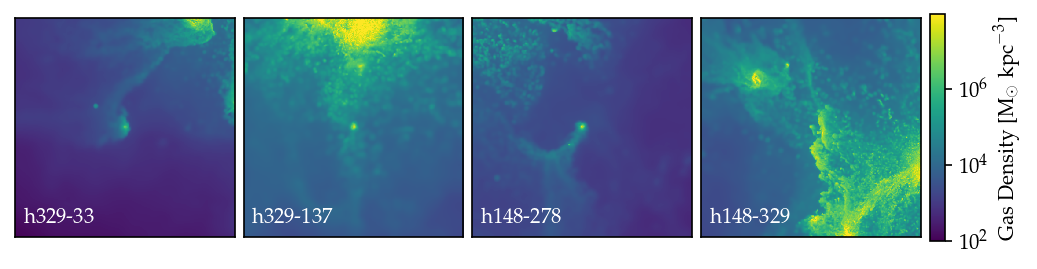

In [17]:
fig = plt.figure(dpi=150,figsize=(8,2))
gs = mpl.gridspec.GridSpec(1,5, width_ratios=[1,1,1,1,0.07], figure=fig)
gs.update(wspace=0.05)
axes = np.array([plt.subplot(gs[i]) for i in range(4)])

sims = ['h329','h329','h148','h148']
z0haloids = [33,137,278,329]
tinfalls = [5.3873, 8.9428, 6.8957, 9.1519]

age = 13.800797497330507
hubble =  0.6776942783267969

fig_i = 0
for sim, z0haloid, tinfall in zip(sims,z0haloids, tinfalls):
    ax = axes[fig_i]
    fig_i += 1
    
    print(f'starting {sim}-{z0haloid}')
    
    if sim=='h148':
        snapnums, haloids = snapnums_h148, haloids_h148
    if sim=='h329':
        snapnums, haloids = snapnums_h329, haloids_h329

    f_base = f'/home/christenc/Data/Sims/{sim}.cosmo50PLK.3072g/{sim}.cosmo50PLK.3072gst5HbwK1BH/snapshots_200bkgdens/{sim}.cosmo50PLK.3072gst5HbwK1BH.'
    if sim=='h148':
        f_base = '/home/christenc/Data/Sims/h148.cosmo50PLK.3072g/h148.cosmo50PLK.3072g3HbwK1BH/snapshots_200bkgdens/h148.cosmo50PLK.3072g3HbwK1BH.'

    lbts = np.array([])
    for i, snapnum in enumerate(snapnums):
        f = f_base + snapnums[i]
        s = pynbody.load(f)
        lbt = age - s.properties['time'].in_units('Gyr')
        lbts = np.append(lbts,lbt)
        
    
    i = np.argmin(np.abs(lbts-tinfall))
    haloid = haloids[z0haloid][i]    

    i = np.argmin(np.abs(lbts-tinfall)) # infall snapshot index
    f = f_base + snapnums[i] # infall snapshot filepath
    s = pynbody.load(f) # load in the snapshot at infall
    s.physical_units()
    h = s.halos()

    halo = h[haloids[z0haloid][i]]
    Rvir = halo.properties['Rvir']/hubble
    
    smin, smax = -int(Rvir*1.5), int(Rvir*1.5)
    gas_vmin, gas_vmax = 1e2, 9e7
    
    print(f'centering halo {haloid}, z=0 halo {z0haloid}')
    pynbody.analysis.angmom.faceon(halo)
    
    print('Making gas image...')
    im = pynbody.plot.sph.image(s.gas[pynbody.filt.Sphere('%s kpc' % str((smax-smin)))], width = '%s kpc' % str(smax-smin), cmap='viridis', 
                                av_z = 'rho', ret_im = True, show_cbar = False, noplot=True)
    
    im = ax.imshow(im, norm=colors.LogNorm(), cmap='viridis', extent = [smin,smax,smin,smax], vmin=gas_vmin, vmax=gas_vmax,origin='lower')
    ax.tick_params(labelleft=False, labelbottom=False, left=False, bottom=False)
    ax.annotate(f'{sim}-{z0haloid}', (0.04, 0.04), xycoords='axes fraction', va='bottom', ha='left', color='w')
    
cax = plt.subplot(gs[-1])
cbar = fig.colorbar(im, cax=cax, label=r'Gas Density [$\mathrm{M}_\odot~\mathrm{kpc}^{-3}$]')
cbar.ax.minorticks_on()
    
fig.show()

starting h329-33
centering halo 17, z=0 halo 33
Making gas image...
starting h329-137
centering halo 24, z=0 halo 137
Making gas image...
starting h148-278
centering halo 33, z=0 halo 278
Making gas image...
starting h148-329
centering halo 93, z=0 halo 329
Making gas image...


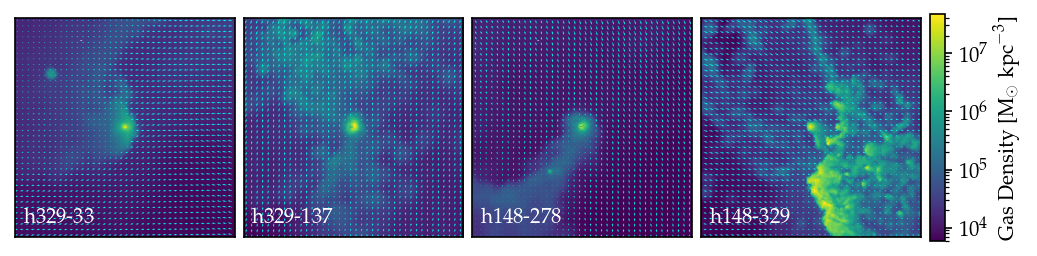

In [16]:
fig = plt.figure(dpi=150,figsize=(8,2))
gs = mpl.gridspec.GridSpec(1,5, width_ratios=[1,1,1,1,0.07], figure=fig)
gs.update(wspace=0.05)
axes = np.array([plt.subplot(gs[i]) for i in range(4)])

sims = ['h329','h329','h148','h148']
z0haloids = [33,137,278,329]
tinfalls = [5.3873, 8.9428, 6.8957, 9.1519]

age = 13.800797497330507
hubble =  0.6776942783267969

fig_i = 0
for sim, z0haloid, tinfall in zip(sims,z0haloids, tinfalls):
    ax = axes[fig_i]
    fig_i += 1
    
    print(f'starting {sim}-{z0haloid}')
    
    if sim=='h148':
        snapnums, haloids = snapnums_h148, haloids_h148
    if sim=='h329':
        snapnums, haloids = snapnums_h329, haloids_h329

    f_base = f'/home/christenc/Data/Sims/{sim}.cosmo50PLK.3072g/{sim}.cosmo50PLK.3072gst5HbwK1BH/snapshots_200bkgdens/{sim}.cosmo50PLK.3072gst5HbwK1BH.'
    if sim=='h148':
        f_base = '/home/christenc/Data/Sims/h148.cosmo50PLK.3072g/h148.cosmo50PLK.3072g3HbwK1BH/snapshots_200bkgdens/h148.cosmo50PLK.3072g3HbwK1BH.'

    lbts = np.array([])
    for i, snapnum in enumerate(snapnums):
        f = f_base + snapnums[i]
        s = pynbody.load(f)
        lbt = age - s.properties['time'].in_units('Gyr')
        lbts = np.append(lbts,lbt)
        
    
    i = np.argmin(np.abs(lbts-tinfall))
    haloid = haloids[z0haloid][i]    

    i = np.argmin(np.abs(lbts-tinfall)) # infall snapshot index
    f = f_base + snapnums[i] # infall snapshot filepath
    s = pynbody.load(f) # load in the snapshot at infall
    s.physical_units()
    h = s.halos()

    halo = h[haloids[z0haloid][i]]
    Rvir = halo.properties['Rvir']/hubble
    
    smin, smax = -int(Rvir*0.6), int(Rvir*0.6)
    gas_vmin, gas_vmax = 1e2, 9e7
    
    print(f'centering halo {haloid}, z=0 halo {z0haloid}')
    pynbody.analysis.angmom.faceon(halo)
    
    print('Making gas image...')
    #im = pynbody.plot.sph.image(s.gas[pynbody.filt.Sphere('%s kpc' % str((smax-smin)))], width = '%s kpc' % str(smax-smin), cmap='viridis', 
    #                            av_z = 'rho', ret_im = True, show_cbar = False, noplot=True)
    #im = ax.imshow(im, norm=colors.LogNorm(), cmap='viridis', extent = [smin,smax,smin,smax], vmin=gas_vmin, vmax=gas_vmax,origin='lower')
    
    im = pynbody.plot.sph.velocity_image(s.gas[pynbody.filt.Sphere('%s kpc' % str((smax-smin)))], width='%s kpc' % str(smax-smin), cmap='viridis', 
                                    vector_color='cyan', av_z='rho', ret_im=True, denoise=False, approximate_fast=False, subplot=ax, show_cbar=False)
    
    
    
    ax.tick_params(labelleft=False, labelbottom=False, left=False, bottom=False)
    ax.annotate(f'{sim}-{z0haloid}', (0.04, 0.04), xycoords='axes fraction', va='bottom', ha='left', color='w')
    
cax = plt.subplot(gs[-1])
cbar = fig.colorbar(im, cax=cax, label=r'Gas Density [$\mathrm{M}_\odot~\mathrm{kpc}^{-3}$]')
cbar.ax.minorticks_on()
    
fig.show()

In [2]:
def read_infall_properties():
    '''Function to read in the data file with quenching timescales and satellite properties at infall.'''
    data = []
    with open(f'../Data/QuenchingTimescales_InfallProperties.data','rb') as f:
        while True:
            try: 
                data.append(pickle.load(f))
            except EOFError:
                break
            
    data = pd.DataFrame(data)
    data['timescale'] = data.tinfall - data.tquench
    
    return data

In [3]:
sims = ['h148']
z0haloids = [278]
haloids = [33]
snaps = ['h148.cosmo50PLK.3072g3HbwK1BH.002048']

Loading snap
Loaded snap, making halo catalog
Made halo catalog
Centering positions
Centering velocities
Getting velocity vector
Transforming snapshot
Making gas image


/Users/hollis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


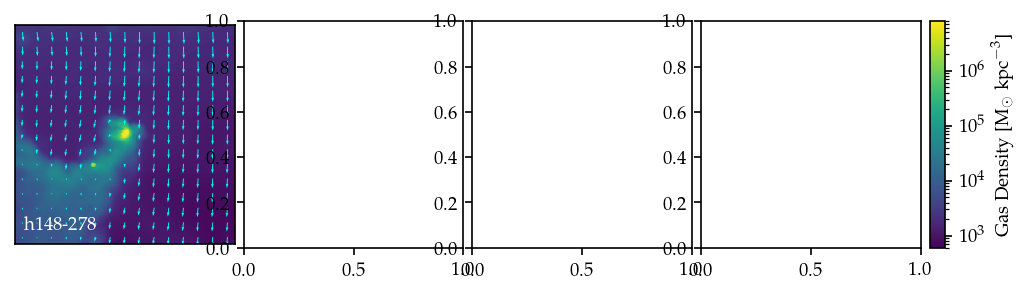

In [12]:
fig = plt.figure(dpi=150,figsize=(8,2))
gs = mpl.gridspec.GridSpec(1,5, width_ratios=[1,1,1,1,0.07], figure=fig)
gs.update(wspace=0.05)
axes = np.array([plt.subplot(gs[i]) for i in range(4)])

data = read_infall_properties()

def vec_to_xform(vec):
    vec_in = np.asarray(vec)
    vec_in = vec_in / np.sum(vec_in ** 2).sum() ** 0.5
    vec_p1 = np.cross([1, 0, 0], vec_in)
    vec_p1 = vec_p1 / np.sum(vec_p1 ** 2).sum() ** 0.5
    vec_p2 = np.cross(vec_in, vec_p1)
    matr = np.concatenate((vec_p2, vec_in, vec_p1)).reshape((3, 3))
    return matr


age = 13.800797497330507
hubble =  0.6776942783267969

fig_i = 0

for sim, z0haloid, haloid, snap in zip(sims, z0haloids, haloids, snaps):
    ax = axes[fig_i]
    fig_i += 1
    d = data[(data.sim==sim)&(data.haloid==z0haloid)]
    
    print('Loading snap')
    s = pynbody.load('../sim_test/'+snap)
    s.physical_units()
    print('Loaded snap, making halo catalog')
    h = s.halos()
    halo = h[haloid]
    host = h[1] # may not always be halo 1! (but probably is)
    print('Made halo catalog')
        
    # below code adapted from pynbody.analysis.angmom.sideon()
    top = s
    print('Centering positions')
    #cen = pynbody.analysis.halo.center(halo, retcen=True)
    tx = pynbody.transformation.inverse_translate(top, cen)
    print('Centering velocities')
    #vcen = pynbody.analysis.halo.vel_center(halo, retcen=True) # commented out to save time when re-running
    tx = pynbody.transformation.inverse_v_translate(tx, vcen)

    print('Getting velocity vector') # may want to get only from inner 10 kpc
    vel = np.average(halo.g['vel'], axis=0, weights=halo.g['mass'])
    vel_host = np.average(host.g['vel'], axis=0, weights=host.g['mass'])
    vel -= vel_host
    
    print('Transforming snapshot')
    trans = vec_to_xform(vel)
    tx = pynbody.transformation.transform(tx, trans)
    

    Rvir = halo.properties['Rvir']/hubble
    
    smin, smax = -int(Rvir*0.6), int(Rvir*0.6)
    gas_vmin, gas_vmax = 6e2, 8e6
    
    # make image
    print('Making gas image')    
    im = pynbody.plot.sph.velocity_image(s.g[pynbody.filt.Sphere('%s kpc' % str((smax-smin)))], width='%s kpc' % str(smax-smin), cmap='viridis', vmax = gas_vmax, vmin=gas_vmin,
                                    vector_color='cyan', vector_resolution = 15, av_z='rho', ret_im=True, denoise=False, approximate_fast=False, subplot=ax, show_cbar=False, quiverkey=False)
    

    from mpl_toolkits.axes_grid.anchored_artists import AnchoredText
    at = AnchoredText(f'{sim}-{z0haloid}', frameon=True, loc=2)
    at.patch.set_boxstyle("")
    
    ax.tick_params(labelleft=False, labelbottom=False, left=False, bottom=False)
    ax.annotate(f'{sim}-{z0haloid}', (0.04, 0.04), xycoords='axes fraction', va='bottom', ha='left', color='w')
    
cax = plt.subplot(gs[-1])
cbar = fig.colorbar(im, cax=cax, label=r'Gas Density [$\mathrm{M}_\odot~\mathrm{kpc}^{-3}$]')
cbar.ax.minorticks_on()
    
fig.savefig('ram_pressure_images.pdf',dpi=300)
fig.show()


In [10]:
np.average(halo.g['vel'], axis=0, weights=halo.g['mass'])

SimArray([-1.37248151e-16,  9.87066681e+00, -1.38485504e-14], 'km s**-1')

In [26]:
np.sum(halo.g['mass']*halo.g['vel'])/np.sum(halo.g['mass'])

ValueError: operands could not be broadcast together with shapes (4163,) (4163,3) 

/Users/hollis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  """


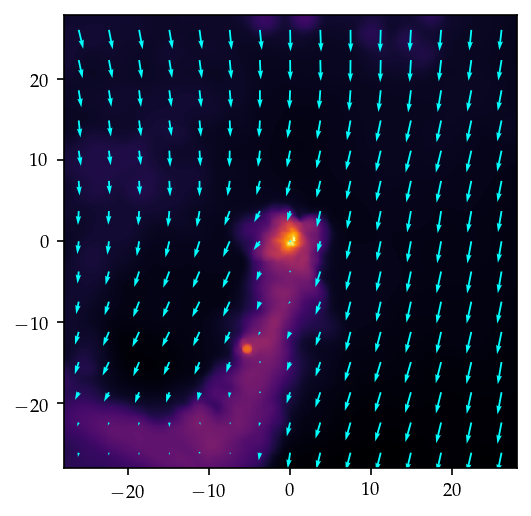

In [43]:
fig, ax = plt.subplots(1,1,dpi=150)
    
im = pynbody.plot.sph.velocity_image(s.g[pynbody.filt.Sphere('%s kpc' % str((smax-smin)))], width='%s kpc' % str(smax-smin), cmap='inferno', vmax=gas_vmax,
                                vector_color='cyan',  vector_resolution = 15,av_z='rho', ret_im=True, denoise=False, approximate_fast=False, subplot=ax, show_cbar=False, quiverkey=False)
fig.show()


SimArray([-3.34034531,  8.38834987, -3.98845121], 'km s**-1')

In [46]:
z_degrees

26.489355333240795

In [7]:
pynbody.transformation

<module 'pynbody.transformation' from '/Users/hollis/anaconda3/lib/python3.7/site-packages/pynbody/transformation.py'>